In [1]:
# Import all necessary packages to run functions
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import QuadGate
import sklearn
from sklearn.decomposition import PCA

# Please note: if trying to display plots in jupyternotebook, must use: %matplotlib inline


def importF(pathname):
    """Import FCS files. Variable input: name of path name to file. Output is a list of Data File Names in FCT Format"""
    # Declare arrays and int
    file = []
    sample = []
    z = 0
    # Read in user input for file path and assign to array file
    pathlist = Path(r"" + str(pathname)).glob("**/*.fcs")
    for path in pathlist:
        path_in_str = str(path)
        file.append(path_in_str)
    # Go through each file and assign the file contents to entry in the array sample
    for entry in file:
        sample.append(FCMeasurement(ID="Test Sample" + str(z), datafile=entry))
        z += 1
    importF.sample = sample
    # Returns the array sample which contains data of each file in folder (one file per entry in array)
    return sample


# *********************************** Gating Fxns *******************************************
# Treg and NonTreg

# add which channels relate to the proteins
def treg():
    """Function for creating and returning the T reg gate"""
    # T reg: Take quad gates for T reg cells and combine them to create single, overall T reg gate
    treg1 = QuadGate((7.063e03, 3.937e03), ("BL1-H", "VL1-H"), region="top left", name="treg1")
    treg2 = QuadGate((5.412e03, 6.382e03), ("BL1-H", "VL1-H"), region="bottom right", name="treg2")
    treg_gate = treg1 & treg2
    return treg_gate


def nonTreg():
    """Function for creating and returning the Non T reg gate"""
    # non T reg: Take quad gates for non T reg cells and combine to create overall non T reg gate
    nonTreg1 = QuadGate((5.233e03, 1.731e03), ("BL1-H", "VL1-H"), region="top left", name="nonTreg1")
    nonTreg2 = QuadGate((2.668e03, 5.692e03), ("BL1-H", "VL1-H"), region="bottom right", name="nonTreg2")
    nonTreg_gate = nonTreg1 & nonTreg2
    return nonTreg_gate


def nk():
    """Function for creating and returning the NK gate"""
    # NK cells: Take quad gates for NK cells and combine them to create single, overall NK gate
    nk1 = QuadGate((6.468e03, 4.861e03), ("BL1-H", "VL4-H"), region="top left", name="nk1")
    nk2 = QuadGate((5.550e03, 5.813e03), ("BL1-H", "VL4-H"), region="bottom right", name="nk2")
    nk_gate = nk1 & nk2
    return nk_gate


def bnk():
    """Function for creating and returning the BNK gate"""
    # Bright NK cells: Take quad gates for bright NK cells and combine them to create single, overall bright NK gate
    bnk1 = QuadGate((7.342e03, 4.899e03), ("BL1-H", "VL4-H"), region="top left", name="bnk1")
    bnk2 = QuadGate((6.533e03, 5.751e03), ("BL1-H", "VL4-H"), region="bottom right", name="bnk2")
    bnk_gate = bnk1 & bnk2
    return bnk_gate


def cd():
    """Function for creating and returning the CD gate"""
    # CD cells: Take quad gates for CD cells and combine them to create single, overall CD gate
    cd1 = QuadGate((9.016e03, 5.976e03), ("RL1-H", "VL4-H"), region="top left", name="cd1")
    cd2 = QuadGate((6.825e03, 7.541e03), ("RL1-H", "VL4-H"), region="bottom right", name="cd2")
    cd_gate = cd1 & cd2
    return cd_gate


def cellCount(sample_i, gate):
    """
    Function for returning the count of cells in a single .fcs. file of a single cell file. Arguments: single sample/.fcs file and the gate of the
    desired cell output.
    """
    # Import single file and save data to a variable --> transform to logarithmic scale
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "RL1-H"])
    # Apply T reg gate to overall data --> i.e. step that detrmines which cells are T reg
    cells = smpl.gate(gate)
    # Number of events (AKA number of cells)
    cell_count = cells.get_data().shape[0]
    # print('Number of Treg cells:' + str(treg_count))
    return cell_count


def rawData(sample_i, gate):
    """
    Function that returns the raw data of certain cell population in a given file. Arguments: sample_i is a single entry/.fcs file and the gate
    of the desired cell population.
    """
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL1-H", "VL4-H", "RL1-H"])
    # Apply T reg gate to overall data --> i.e. step that detrmines which cells are T reg
    cells = smpl.gate(gate)
    # Get raw data of t reg cells in file
    cell_data = cells.get_data()
    return cell_data


def tcells(sample_i, treg_gate, nonTreg_gate, i):
    """
    Function that is used to plot the Treg and NonTreg gates. Treg (yellow) and Non Treg (green). sample_i is an indivual flow cytommetry
    file/data.
    """
    # Assign data of current file for analysis to variable smpl and transform to log scale
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL1-H"])
    # CD25 v. Foxp33: VL1 v. BL1
    # Treg
    # Apply T reg gate to overall data --> step that determines which cells are Treg
    treg_cells = smpl.gate(treg_gate)
    # Non Tregs
    # Apply non T reg gate to overall data --> step that detrmines which cells are non T reg
    nonTreg_cells = smpl.gate(nonTreg_gate)

    # Declare figure and axis
    _, ax = plt.subplots() # ???????? unused fig, but need to leave there to make sure right assignment for ax?
    # Plot the treg gate
    treg_cells.plot(["BL1-H", "VL1-H"], color="y")
    # Plot the non Treg gate
    nonTreg_cells.plot(["BL1-H", "VL1-H"], color="g")
    # Plot all of the cells in the file
    print(i)
    ax.set_title("T Reg + Non T Reg - Gating - File " + str(i), fontsize=20)
    smpl.plot(["BL1-H", "VL1-H"])

    bar_T = ax.bar(np.arange(0, 10), np.arange(1, 11), color="y")
    bar_NT = ax.bar(np.arange(0, 10), np.arange(30, 40), bottom=np.arange(1, 11), color="g")
    ax.legend([bar_T, bar_NT], ("T Reg", "Non T Reg"), loc="upper left")
    plt.show()


def nk_bnk_plot(sample_i, nk_gate, bnk_gate, i):
    """
    Function that plots the graph of NK and Bright NK cells (both are determined by same x, y-axis). Arguemnt 1: current sample (a single file).
    Argument 2: the gate for NK. Argument 3: the gate for bright NK.
    """
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL4-H", "RL1-H"])

    # CD3 v. CD56: VL4 v. BL1
    # NK
    # Apply NK gate to overall data --> step that determines which cells are NK
    nk_cells = smpl.gate(nk_gate)
    # CD56 Bright NK
    # Apply Bright NK gate to overall data --> step that determines which cells are Bright NK
    bnk_cells = smpl.gate(bnk_gate)

    _, ax1 = plt.subplots()
    ax1.set_title("CD56 BrightNK + NK - Gating - File " + str(i), fontsize=20)
    nk_cells.plot(["BL1-H", "VL4-H"], color="y", label="NK")
    bnk_cells.plot(["BL1-H", "VL4-H"], color="g", label="Bright NK")
    smpl.plot(["BL1-H", "VL4-H"])

    bar_NK = ax1.bar(np.arange(0, 10), np.arange(1, 11), color="y")
    bar_BNK = ax1.bar(np.arange(0, 10), np.arange(30, 40), bottom=np.arange(1, 11), color="g")
    ax1.legend([bar_NK, bar_BNK], ("NK", "Bright NK"), loc="upper left")
    plt.show()


def cd_plot(sample_i, cd_gate, i):
    """
    Function that plots the graph of CD cells. Argument 1: current sample (a single file). Argument 2: the gate for CD cells. Argument 3: the value
    of the current i in a for loop --> use
    when plotting multiple files.
    """
    smpl = sample_i.transform("hlog", channels=["BL1-H", "VL4-H", "RL1-H"])
    # CD3 v. CD8: VL4 v. RL1
    # CD3+CD8+
    # Apply CD cell gate to overall data --> step that determines which cells are CD
    cd_cells = smpl.gate(cd_gate)

    _, ax2 = plt.subplots()
    ax2.set_title("CD3+CD8+ - Gating - File " + str(i), fontsize=20)
    cd_cells.plot(["RL1-H", "VL4-H"], color="b")
    smpl.plot(["RL1-H", "VL4-H"])

    bar_CD = ax2.bar(np.arange(0, 10), np.arange(1, 11), color="b")
    ax2.legend([bar_CD], ("CD3+8+"), loc="upper left")
    plt.show()


def count_data(sampleType, gate):
    """
    Used to count the number of cells and store the data of all of these cells in a folder with multiple files --> automates the process sampleType
    is NK or T cell data, gate is the desired cell population.
    Sample type: is the overall importF assignment for T or NK (all the T cell files, all NK cell files)
    """
    # declare the arrays to store the data
    count_array = []
    data_array = []
    # create the for loop to file through the data and save to the arrays
    # using the functions created above for a singular file
    for _, sample in enumerate(sampleType):
        count_array.append(cellCount(sample, gate))
        data_array.append(rawData(sample, gate))
    # returns the array for count of cells and the array where each entry is the data for the specific cell population in that .fcs file
    return count_array, data_array


def plotAll(sampleType, check, gate1, gate2):
    """
    Ask the user to input 't' for t cell, 'n' for nk cell, and 'c' for cd cell checks are used to determine if user input a T-cell, NK-cell, or
    CD-cell gate automates the process for plotting multiple files.
    """
    if check == "t":
        for i, sample in enumerate(sampleType):
            tcells(sample, gate1, gate2, i)
    elif check == "n":
        for i, sample in enumerate(sampleType):
            nk_bnk_plot(sample, gate1, gate2, i)
    elif check == "c":
        for i, sample in enumerate(sampleType):
            cd_plot(sample, gate1, i)


/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.7/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)


What is the name of the T plate folder?: /home/heatherm/gating/Tall
What is the name of the NK plate folder?: /home/heatherm/gating/NKall


0


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


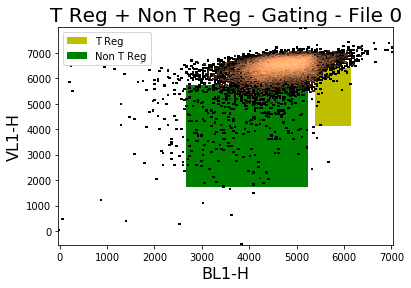

1


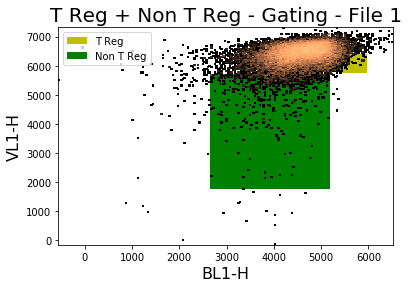

2


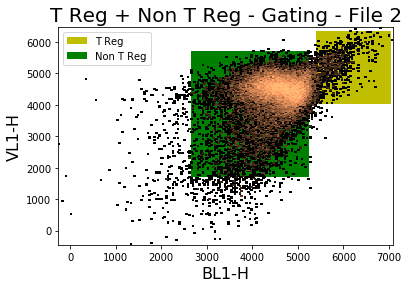

3


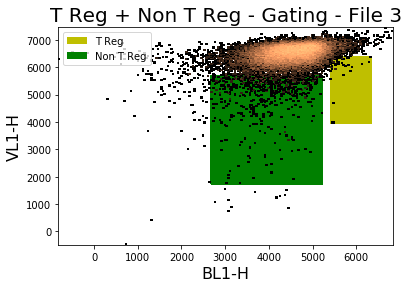

4


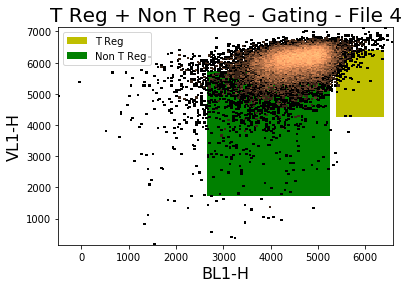

5


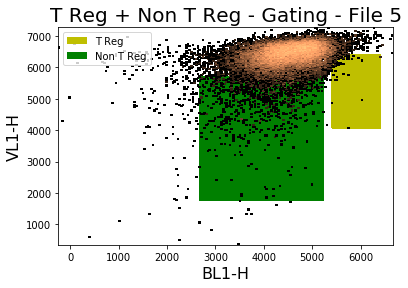

6


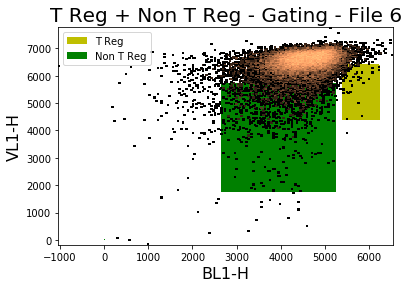

7


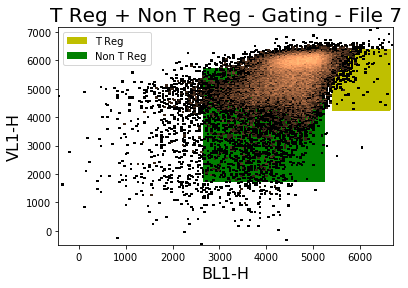

8


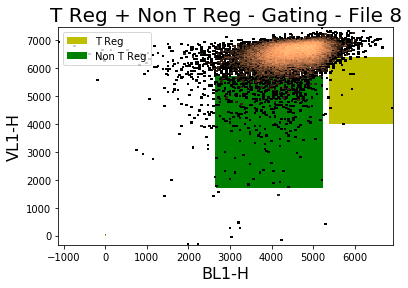

9


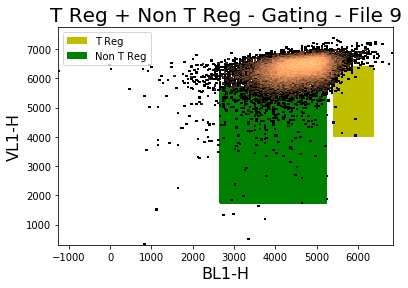

10


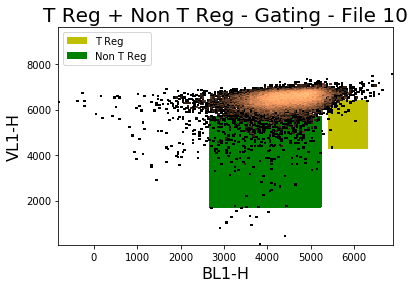

11


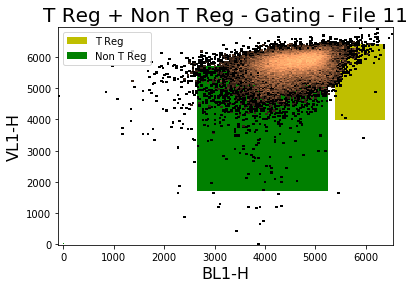

12


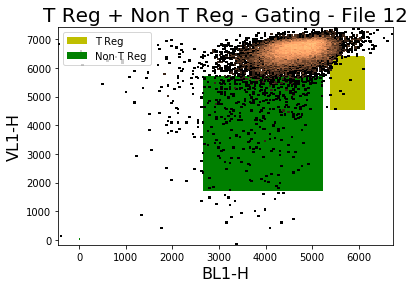

13


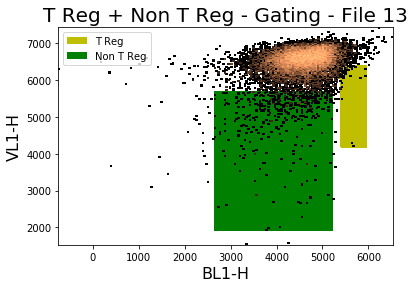

14


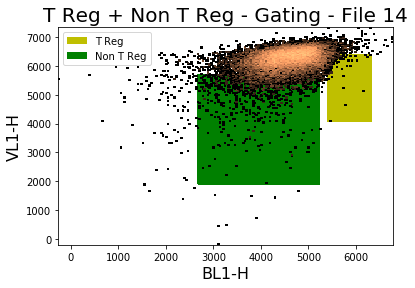

15


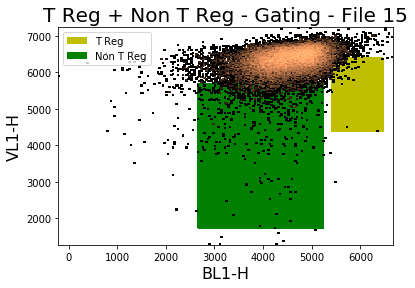

16


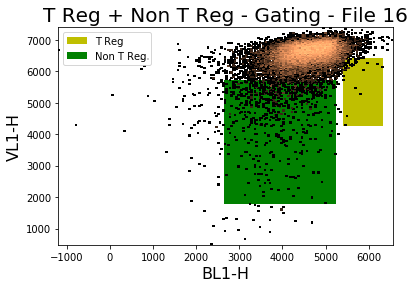

17


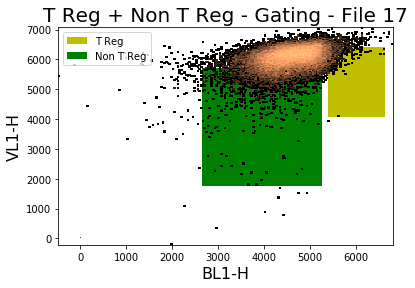

18


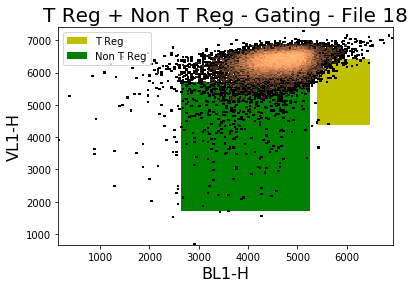

19


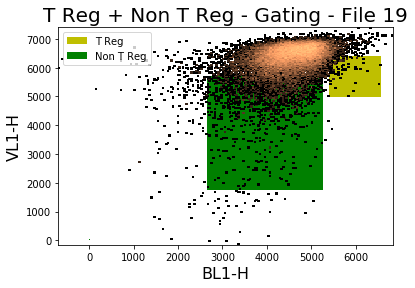

20


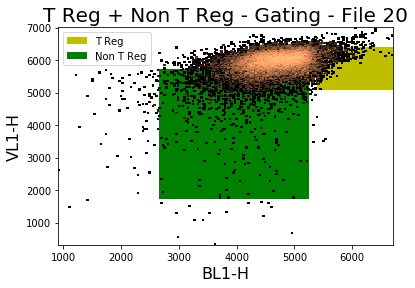

21


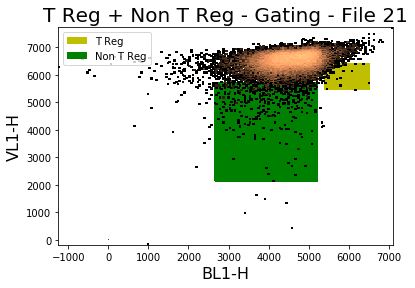

22


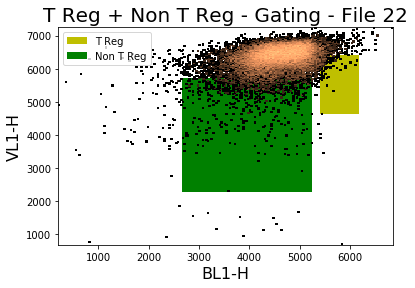

23


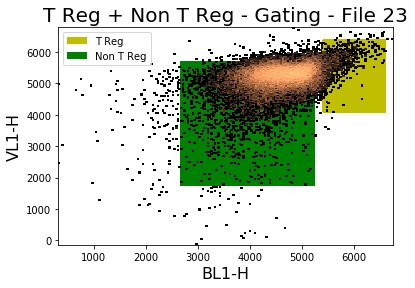

24


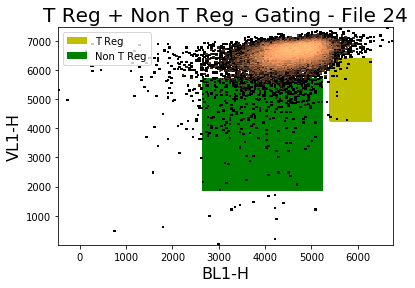

25


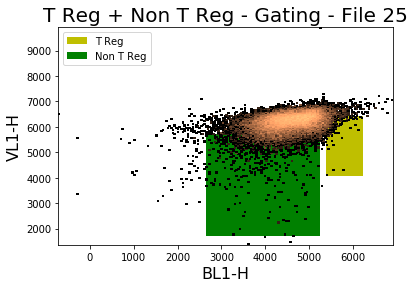

26


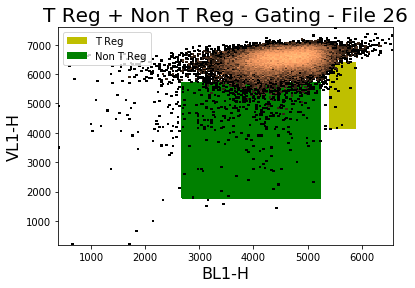

27


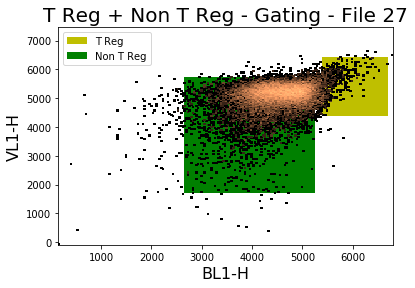

28


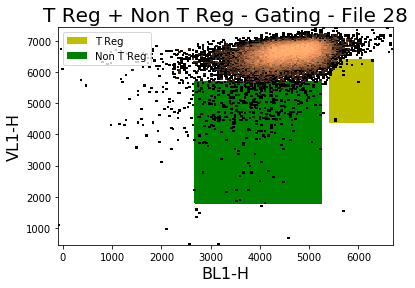

29


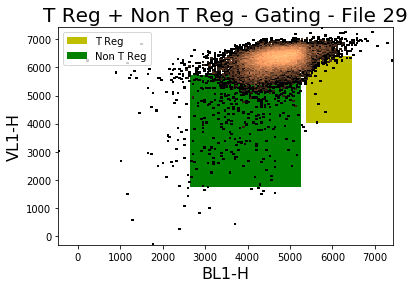

30


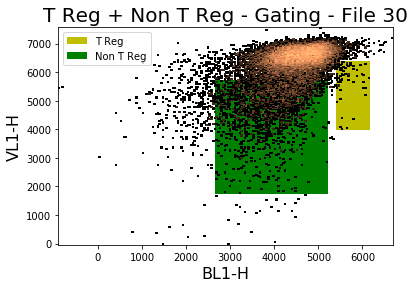

31


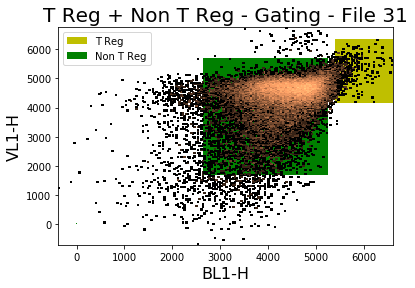

32


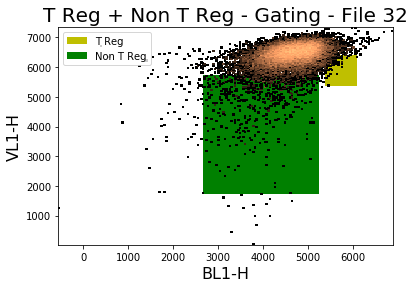

33


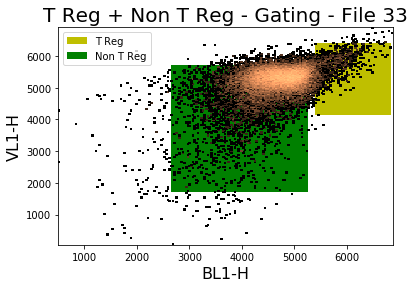

34


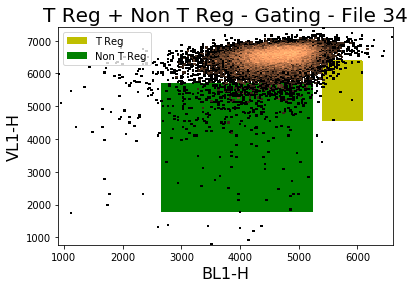

ValueError: cannot reshape array of size 523061 into shape (29125,32)

In [2]:
tplate = input('What is the name of the T plate folder?:')
tsample = importF(tplate)

nkplate = input('What is the name of the NK plate folder?:')
nksample = importF(nkplate)

treg_gate = treg()
nonTreg_gate = nonTreg()
nk_gate = nk()
bnk_gate = bnk()
cd_gate = cd()

# T cells: T regs and Non T Regs (gates must be in order T reg, non T Reg)!!!!!!!!!!!!!!!!!!
plotAll(tsample, "t", treg_gate, nonTreg_gate)
# NK cells: NK and Bright NK (gates must be in order of nk and bnk)
plotAll(nksample, "n", nk_gate, bnk_gate)
# CD cells: CD56 (gate is cd)
plotAll(nksample, "c", cd_gate, _)